## Import libraries and modules

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats as stats
import sklearn
from matplotlib import pyplot as plt
import regex
import statsmodels.api as sm
from itertools import combinations
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import random
import pickle
from geopy.distance import geodesic
from scipy import interpolate

# GEOPANDAS

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Data Summary and Goal

The data provided is a collection of records of successful house sales and those homes' living attributes, such as:

1. Number of Floors
2. Amount of living space
3. Price
4. Number of assorted rooms (bathrooms, bedrooms)
5. Location
6. ETC.


The goal of this project is to create a relatively accurate prediction model for the prices that future houses sell for. We will explore how different factors affect the pricing the homes, given the data, and compile the most important features into a compatible regression model.

The final result will be a flexible prediciton model(s) that allow for easy prediction of future price sales given certain criteria!

# Cleaning

## Missing and duplicates

In [2]:
# Import data
df = pd.read_csv('../my_project_workspace_repo/data/kc_house_data.csv')

# Display shape and .head()
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Check data types and missing values
df.info()
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Examine missing values

# df[df['yr_renovated'].isna()]
df['yr_renovated'].fillna(0, inplace=True)
# Replace all of the Null values with zeros so we can get a better idea of the amount of missing values in this column.
percent_not_renovated = df[df['yr_renovated'] == 0].value_counts().sum() / df['yr_renovated'].value_counts().sum()
# This is the percentage of houses that weren't renovated!



df['waterfront'].fillna(0., inplace=True)
# df['view'].unique()
# The waterfront column only has a 1 or a 0 to specify if the house has a waterfront. The NaN values here can be treated as no waterfront.

df.dropna(how = 'any', inplace=True)
# Drop all rows with missing 'view' data

In [5]:
# Dealing with the 'sqft_basement' column. 

# Checking to see if my guess that all of the elements in the series are str types is true
for x in df['sqft_basement']:
    not_str_sqft = 0
    if type(x) != str:
        not_str_sqft += 1
        

# All of the elements in this series are of type str
if not_str_sqft == 0:
    # Replacing original series
    converted_to_str = pd.to_numeric(df['sqft_basement'], errors='coerce')
    df['sqft_basement'] = converted_to_str
    # Confirm that the series has been converted successfully
    if df['sqft_basement'].dtype == np.float64:
        pass
    



In [6]:
# Now have to convert all of the dates in the 'date' column to something I can work with (a datetime object)
from datetime import datetime

for x in df['date']:
    not_str_date = 0
    if type(x) != str:
        not_str_date += 1
        
datetime_objects = []
if not_str_date == 0:
    for string in df['date']:
        string = pd.to_datetime(string)
        datetime_objects.append(string)
    df['date'] = datetime_objects

In [7]:
# Duplicate check
df.set_index(['id'], inplace=True)

In [8]:
print(df.index.duplicated().sum())
# df[df.index.duplicated()].head()
df[df.index == 6021501535]

# 177 duplicate IDs
# It seems as if these duplicate IDs truly do indicate the same house, but simply sold more than once.

177


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
6021501535,2014-07-25,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500
6021501535,2014-12-23,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500


Distinguish duplicates by combining ID series with Date series and comparing.

In [9]:
df2=df.reset_index()
df2.apply(lambda r:str(r.id)+str(r.date),axis=1).duplicated().sum()

0

In [10]:
df = df2

## Date and season and Age

In [11]:
df['sale_year'] = df.apply(lambda x: x.date.year, axis=1)
print(df['sale_year'].value_counts())

# Why were there almost 3 times as many sales in 2015 compared to 2014?

2014    14588
2015     6946
Name: sale_year, dtype: int64


In [12]:
df['sale_month'] = df.apply(lambda x: x.date.month, axis=1)

print(df['sale_month'].value_counts())

5     2408
4     2218
7     2210
6     2177
8     1933
10    1871
3     1867
9     1764
12    1464
11    1407
2     1243
1      972
Name: sale_month, dtype: int64


In [13]:
# Age of house at sale?
df['age'] = df['sale_year'] - df['yr_built']

# A couple homes (12 to be exact) have an age of -1. This is odd and needs looking into
df.age.replace(-1, 0, inplace=True)
df['age'].value_counts().sort_index()


0      441
1      284
2      174
3      165
4      117
      ... 
111     50
112     33
113     28
114     69
115     26
Name: age, Length: 116, dtype: int64

In [14]:
# df[df['age'] == -1][['yr_built', 'sale_year']]
# All 12 of these houses were built the year after they were bought! Indicates potentially high demand. Am curious where these houses are located
# They are all very expensive homes
# All in the wealthy section of the county?

Spring    6493
Summer    6320
Fall      5042
Winter    3679
Name: season, dtype: int64


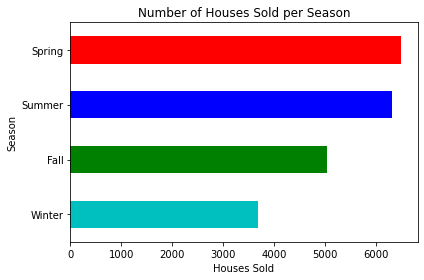

In [15]:
# Convert the dates to season. Now we know which season each house was sold in. 
# month = []
# for x in df['date']:
#     month.append(x.month)
# df['month'] = month
# df['season'] = df['month']%12 // 3 + 1
quart_dict={
            1:'Winter',
            2:'Winter',
            3:'Spring',
            4:'Spring',
            5:'Spring',
            6:'Summer',
            7:'Summer',
            8:'Summer',
            9:'Fall',
            10:'Fall',
            11:'Fall',
            12:'Winter'
            }
df['season']=df.sale_month.map(quart_dict)



# Visualize the amount of houses sold per season
print(df['season'].value_counts())
df['season'].value_counts().sort_values().plot(kind = 'barh', color=['c','g','b','r'])
plt.title('Number of Houses Sold per Season')
plt.xlabel('Houses Sold')
plt.ylabel('Season')
plt.tight_layout()

## Renovations

In [16]:
# Categorize renovation's ages (How recent was the house renovated?)
NO_RENO=-100
df['renovation_age']=df.apply(lambda r:r.sale_year-r.yr_renovated if r.yr_renovated>0 else NO_RENO,axis=1)
def renovation_status(obs):
    s=''
    x=obs['renovation_age']
    if(x==NO_RENO):
        s='Never'
    elif(x>24):
        s='25+'
    elif(x>9):
        s='10-24'
    elif(x>4):
        s='5-9'
    elif(x>1):
        s='2-4'
    elif(x==1 or x==0 or x==-1):
        s='Recent'
    return s

df['renovation_status']=df.apply(renovation_status,axis=1)
df.renovation_status.value_counts()

Never     20791
10-24       260
25+         229
Recent      111
5-9         108
2-4          35
Name: renovation_status, dtype: int64

_____________________________________________________________________________________________________________________________________________________

## Outliers

In [60]:
## Outliers
#Want to look at variables which are not categorical.
df_quant=df[['sqft_living','sqft_lot','sqft_above', 'sqft_basement','sqft_living15','age', 'price', 'floors', 'bathrooms', 'bedrooms', 'grade', 'condition']]
#Calculate Z_Scores for all the quantitative columns.
df_zScores=df_quant.apply(stats.zscore)
df_zScores.head()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,age,price,floors,bathrooms,bedrooms,grade,condition
0,-0.980819,-0.228148,-0.735216,NaN,-0.943359,0.533731,-0.869162,-0.915398,-1.451646,-0.402680,-0.560649,-0.629726
1,0.534291,-0.189675,0.460832,NaN,-0.432488,0.669894,-0.005621,0.937163,0.174721,-0.402680,-0.560649,-0.629726
2,-1.427722,-0.123023,-1.230549,NaN,1.070931,1.316669,-0.983627,-0.915398,-1.451646,-1.482141,-1.413443,-0.629726
3,-0.130613,-0.243856,-0.892273,NaN,-0.914166,0.193323,0.174681,-0.915398,1.150541,0.676781,-0.560649,2.444177
4,-0.435815,-0.169423,-0.131151,NaN,-0.271929,-0.521533,-0.082113,-0.915398,-0.150553,-0.402680,0.292146,-0.629726


In [61]:
#Define an extreme threshold.  Z-Scores above this threshold will be flagged.
threshold=10
out_bool=df_zScores.apply(lambda x:abs(x)>threshold)
out_bool['totals']=out_bool.apply(sum,axis=1)
out_bool.sum()

sqft_living       2
sqft_lot         35
sqft_above        0
sqft_basement     0
sqft_living15     0
age               0
price            10
floors            0
bathrooms         0
bedrooms          1
grade             0
condition         0
totals           48
dtype: int64

In [62]:
out_bool.totals.value_counts().sort_index()

0    21487
1       46
2        1
Name: totals, dtype: int64

In [64]:
#We can choose to drop all observations which have 1 or two extreme values.
outliers=out_bool.totals.nlargest(47)
df_clean=df.drop(outliers.index.values,axis=0)
df_clean.shape

(21487, 51)

# Visualizations

## Price Distribution

In [17]:
price_mean = df['price'].mean()
price_std = df['price'].std()
price_mean, price_std

(540057.663833937, 366059.58123129635)

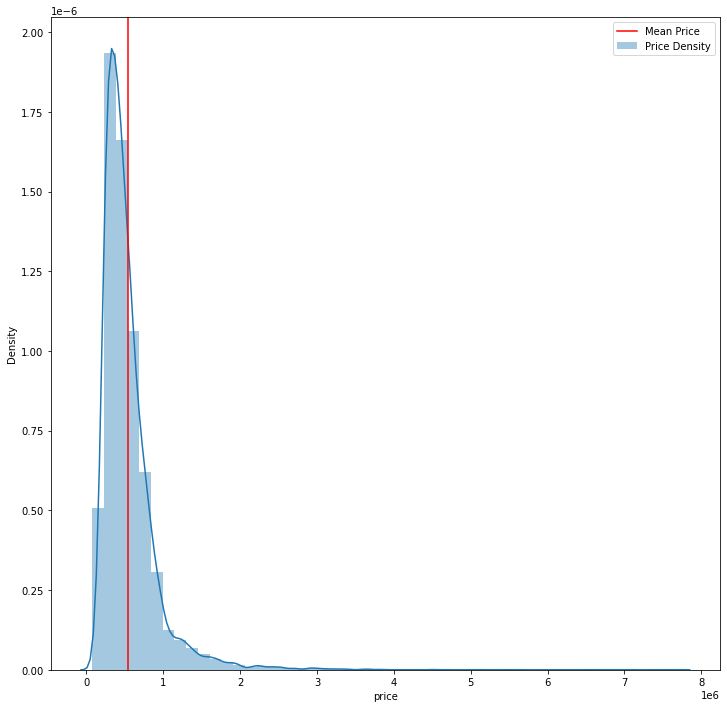

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.distplot(df['price'], label='Price Density')
plt.axvline(price_mean, color='red', label='Mean Price')
plt.legend()

In [19]:
avg_price_yr=df.groupby(['yr_built']).price.mean()
avg_price_yr.sort_index()

yr_built
1900    581536.632184
1901    557108.344828
1902    673192.592593
1903    480958.195652
1904    583867.755556
            ...      
2011    544648.384615
2012    527436.982353
2013    678811.430000
2014    683923.702509
2015    759970.947368
Name: price, Length: 116, dtype: float64

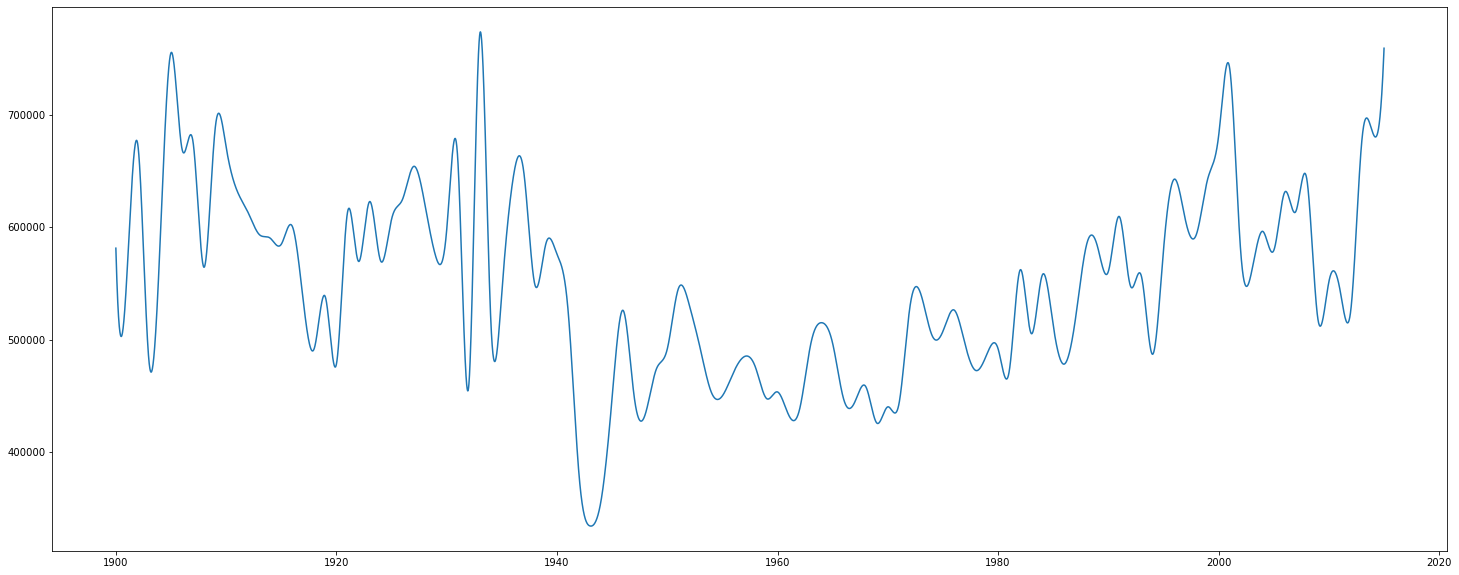

In [20]:
# Interpolate to make more smooth
T=avg_price_yr.index
X=np.linspace(T.min(),T.max(),10000)
Y=avg_price_yr.values
spl=interpolate.make_interp_spline(T,Y,3)
test=spl(X)

fig,ax=plt.subplots(figsize=(25,10))
ax.plot(X,test)

Text(0.5, 1.0, 'House price boxplot')

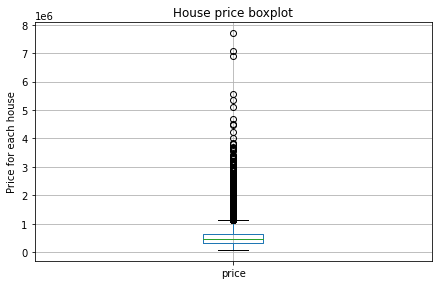

In [21]:
df.boxplot('price')
plt.tight_layout()
plt.ylabel('Price for each house')
plt.title('House price boxplot')

## Floors

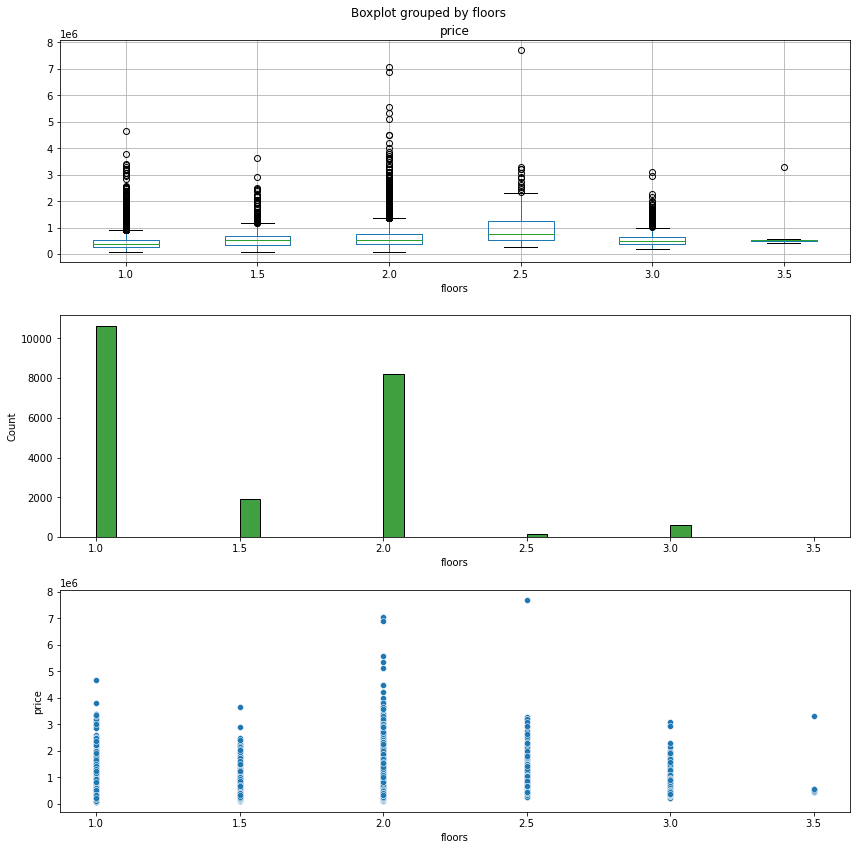

In [22]:
# Floor distributions
fig, axes = plt.subplots(3,1, figsize=(12,12))



df.boxplot('price', by='floors', figsize=(12,12), ax=axes[0])



sns.histplot(df['floors'], color = 'green', ax=axes[1])


sns.scatterplot(x='floors', y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()


The number of floors in a house does not seem to have any effect on the pricing.

## Sqft_living

price          1.000000
sqft_living    0.701587
Name: price, dtype: float64

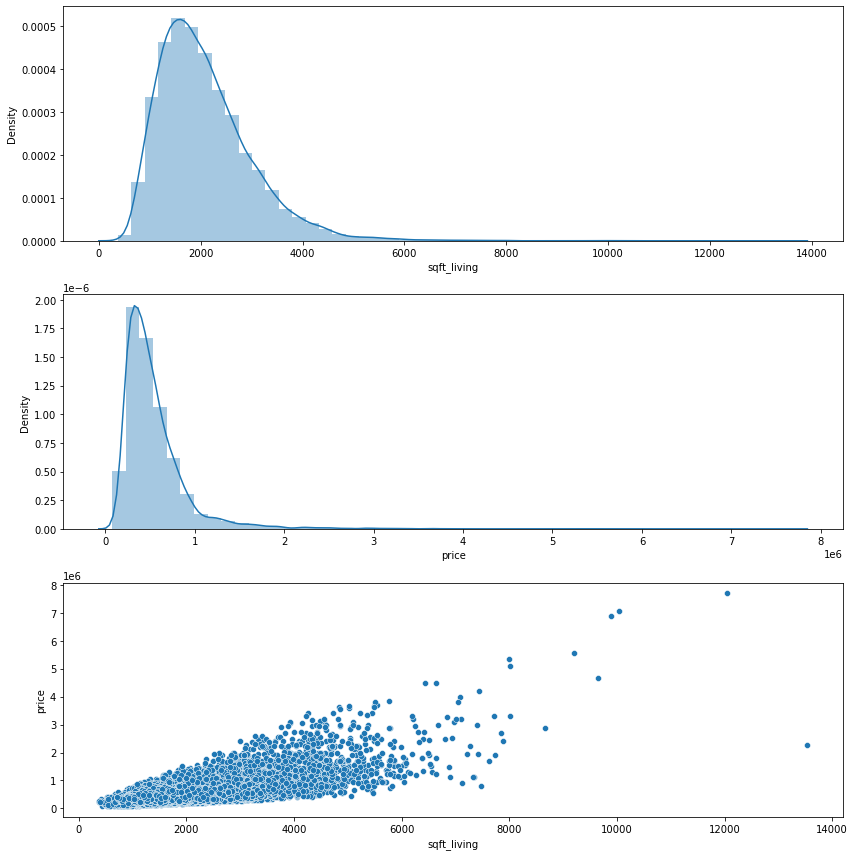

In [23]:
# Living space relationship
fig, axes = plt.subplots(3,1, figsize=(12,12))



sns.distplot(df['sqft_living'], ax=axes[0])



sns.distplot(df['price'], ax=axes[1])


sns.scatterplot(x='sqft_living', y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()
# The average of the living square feet is displayed with a red line on the pdf graph

# The results indicate a clear correlation between the living space size and the price. As living space size goes up, generally so does price.

# The strong correlation coefficient between the two variables helps validate this claim
df.corr()['price'][df.corr()['price'] >= .70]



The amount of living space seems to have a significant positive effect on price.

## Sqft_outside

We know that the square footage of the lot includes the square footage of the house. Using this, we can use simple arithmetic to create a new variable that better helps to examine our data, 'sqft_outside', which represents only the outside space.

We did the same thing for the neighbors' homes.

In [24]:
df['sqft_outside']=df['sqft_lot']-df['sqft_living']
df['sqft_outside15']=df['sqft_lot15']-df['sqft_living15']

In [25]:
# df['sqft_outside15'].nsmallest(15)

Since it is possible for the neighborhood average lot size to be samller than the average living space, we can get negative values, and therefore we will be dropping the neighborhood 'outside' and 'lot' variables from the analysis.

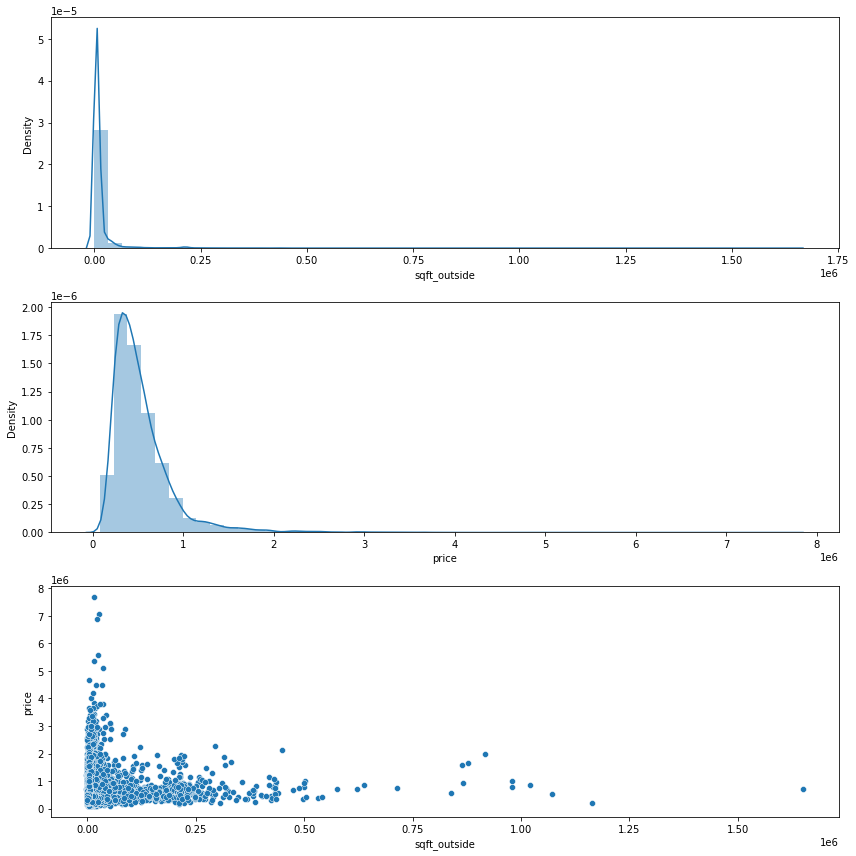

In [26]:
# Outside space relationship
category = 'sqft_outside'
fig, axes = plt.subplots(3,1, figsize=(12,12))



sns.distplot(df[category], ax=axes[0])



sns.distplot(df['price'], ax=axes[1])


sns.scatterplot(x=category, y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()

Two important observations:
1. A LOT of observations that have a zero value. (No outside space)
2. There doesn't seem to be any noticeable relationship between the amount of outside space and the pricing of the house

## Grade

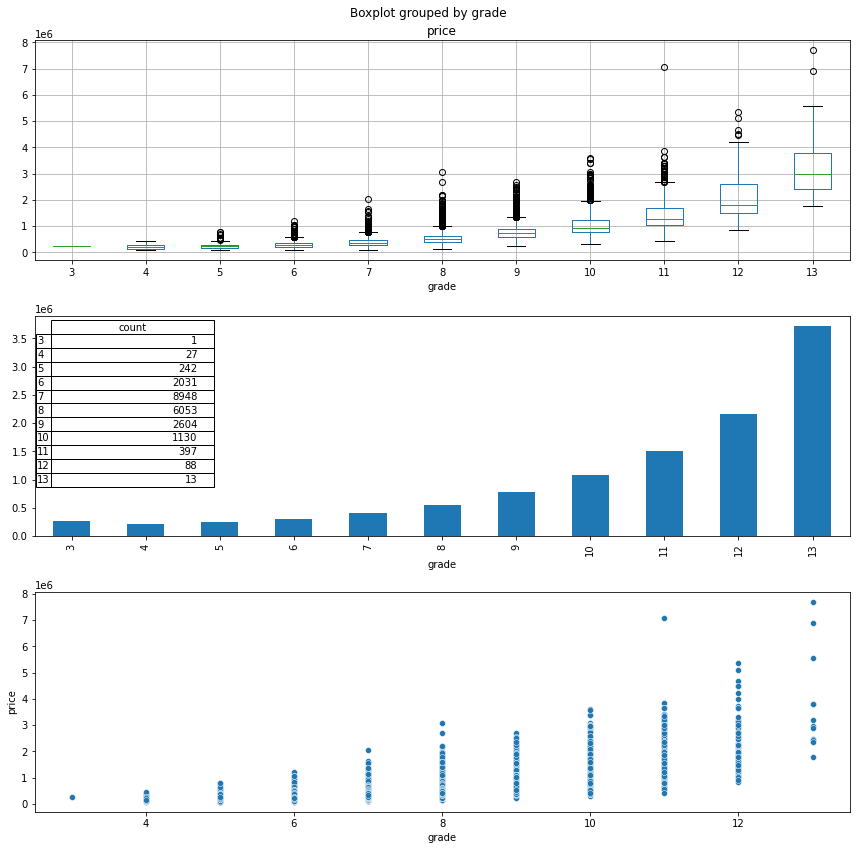

In [27]:
# Grade distributions
category='grade'

fig, axes = plt.subplots(3,1, figsize=(12,12))



df.boxplot('price', by=category, figsize=(20,10), ax=axes[0])

grouped_prices=df.groupby(category).price
mean_count=grouped_prices.agg(['mean','count'])
pd.plotting.table(axes[1],mean_count[['count']],loc='upper left',colWidths=[0.2,0.2])
mean_count['mean'].plot(kind='bar',ax=axes[1])




sns.scatterplot(x=category, y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()

Grade seems to have a significant positive effect on price.

## Bedrooms

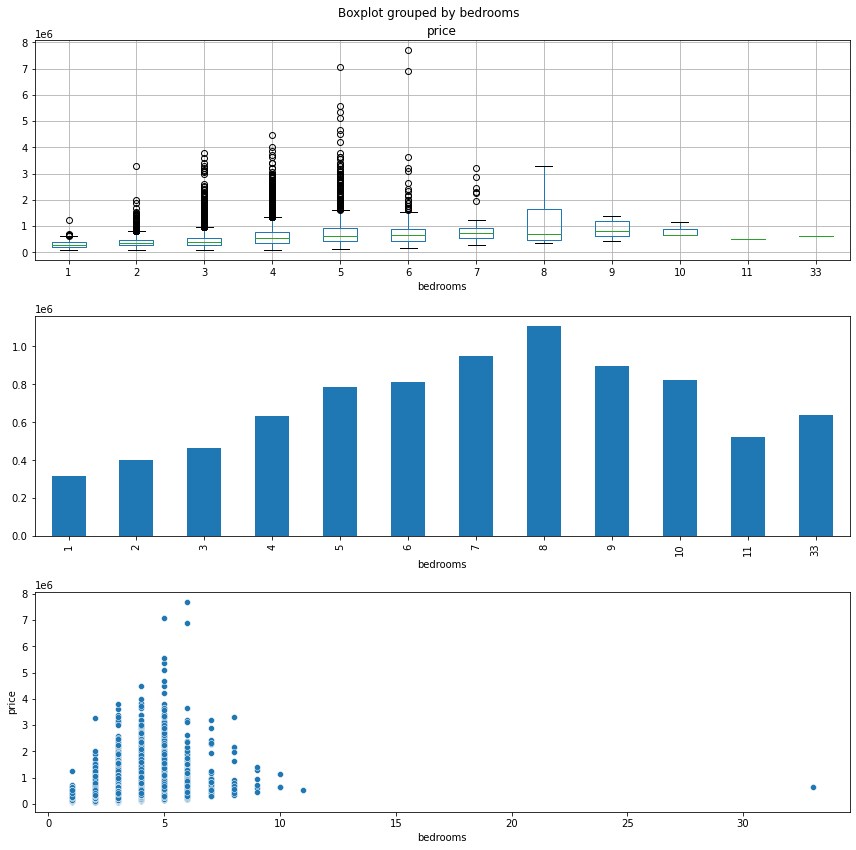

In [28]:
# Bedroom Relationship
category='bedrooms'

fig, axes = plt.subplots(3,1, figsize=(12,12))



df.boxplot('price', by=category, figsize=(20,10), ax=axes[0])

grouped_prices=df.groupby(category).price
mean_count=grouped_prices.agg(['mean','count'])
mean_count['mean'].plot(kind='bar',ax=axes[1])




sns.scatterplot(x=category, y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()

It is interesting to see that the relationship between bedrooms and price is not purely linear. In fact starting at roughly 8 bedrooms, adding more seems to have a negative effect on price.

## Bathrooms

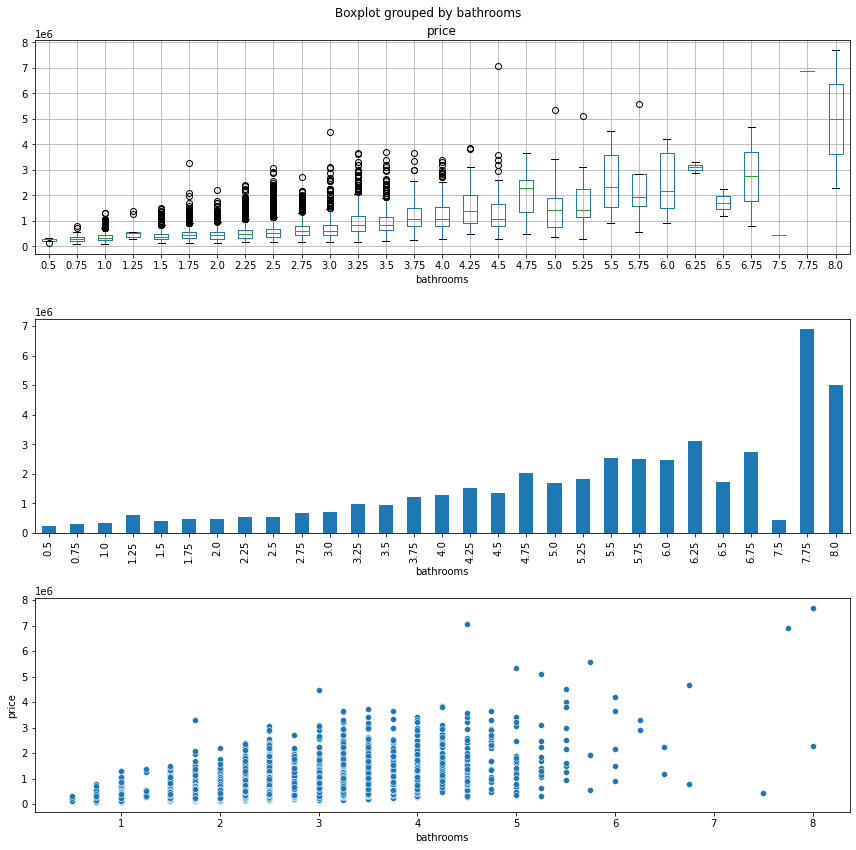

In [29]:
# Bathroom relationship
category='bathrooms'

fig, axes = plt.subplots(3,1, figsize=(12,12))



df.boxplot('price', by=category, figsize=(20,10), ax=axes[0])

grouped_prices=df.groupby(category).price
mean_count=grouped_prices.agg(['mean','count'])
mean_count['mean'].plot(kind='bar',ax=axes[1])




sns.scatterplot(x=category, y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()

It doesn't appear that more bathrooms have a positive effect on price that cannot be explained by the overall size of the house.

## Condition

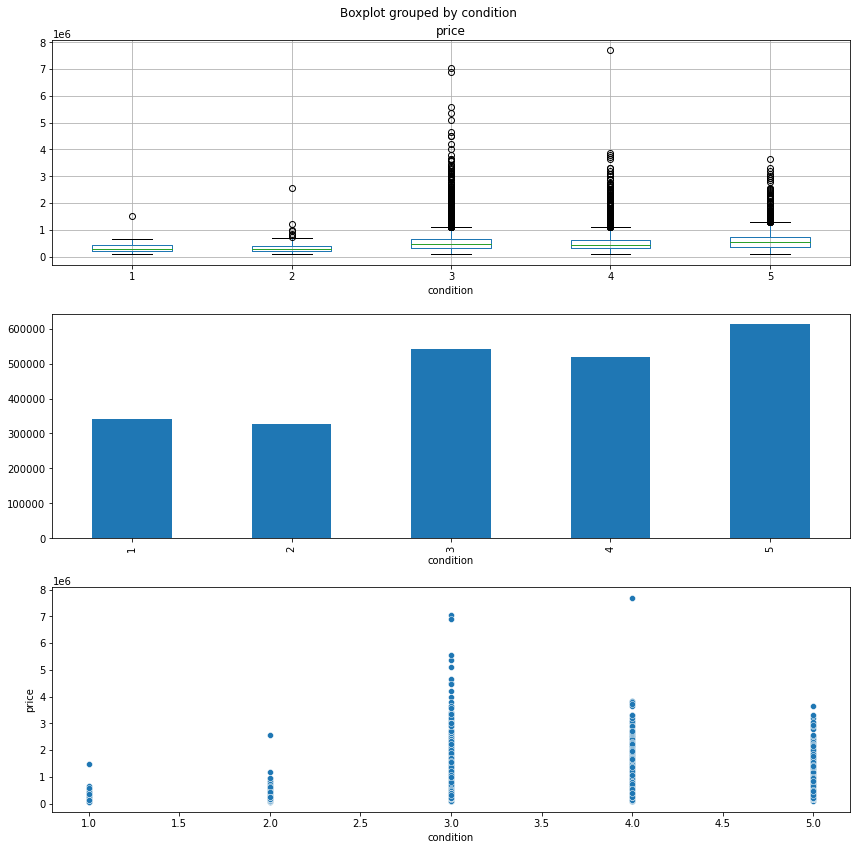

In [30]:
# Condition Relationship
category='condition'

fig, axes = plt.subplots(3,1, figsize=(12,12))



df.boxplot('price', by=category, figsize=(20,10), ax=axes[0])

grouped_prices=df.groupby(category).price
mean_count=grouped_prices.agg(['mean','count'])
mean_count['mean'].plot(kind='bar',ax=axes[1])




sns.scatterplot(x=category, y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()

Interestingly the condition of the house seems to have basically no positive effect on the pricing of the house, despite what common sense might dictate.

Given our objectives, this might be worth exploring further.

## Renovation Status

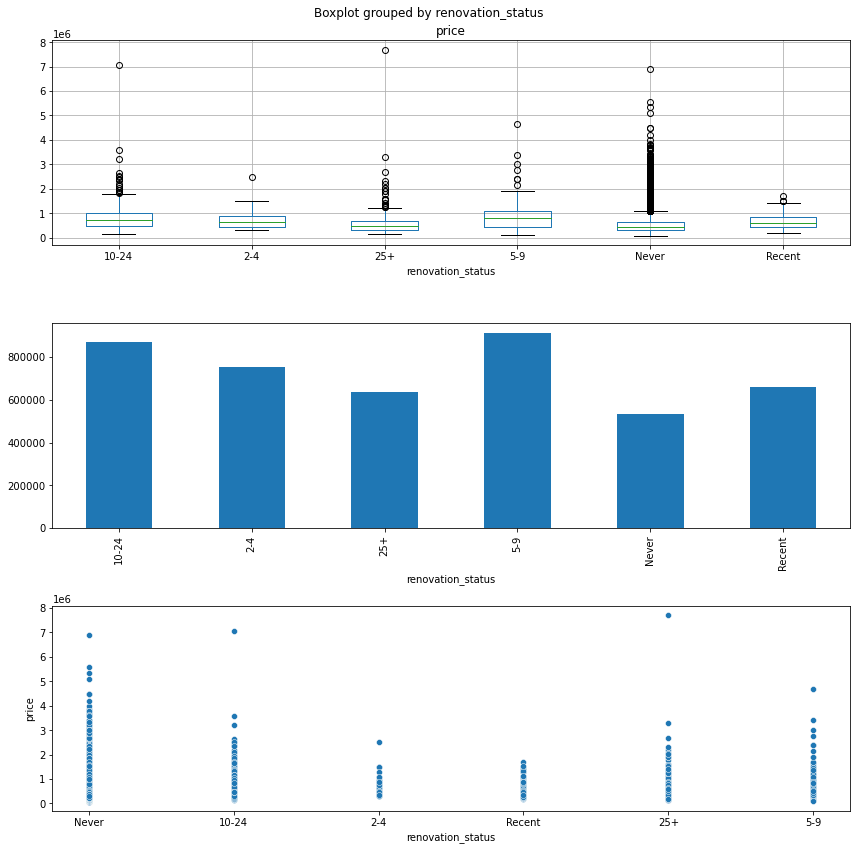

In [31]:
# Renovation Status Relationship
category='renovation_status'

fig, axes = plt.subplots(3,1, figsize=(12,12))



df.boxplot('price', by=category, figsize=(20,10), ax=axes[0])

grouped_prices=df.groupby(category).price
mean_count=grouped_prices.agg(['mean','count'])
mean_count['mean'].plot(kind='bar',ax=axes[1])




sns.scatterplot(x=category, y='price', data=df, ci=None, ax = axes[2])

plt.tight_layout()

The renovation status of the house does not seem to have any noticeable effect on the pricing of the house.

## Zipcode

<AxesSubplot:title={'center':'Average Prices by Zipcode'}, xlabel='zipcode'>

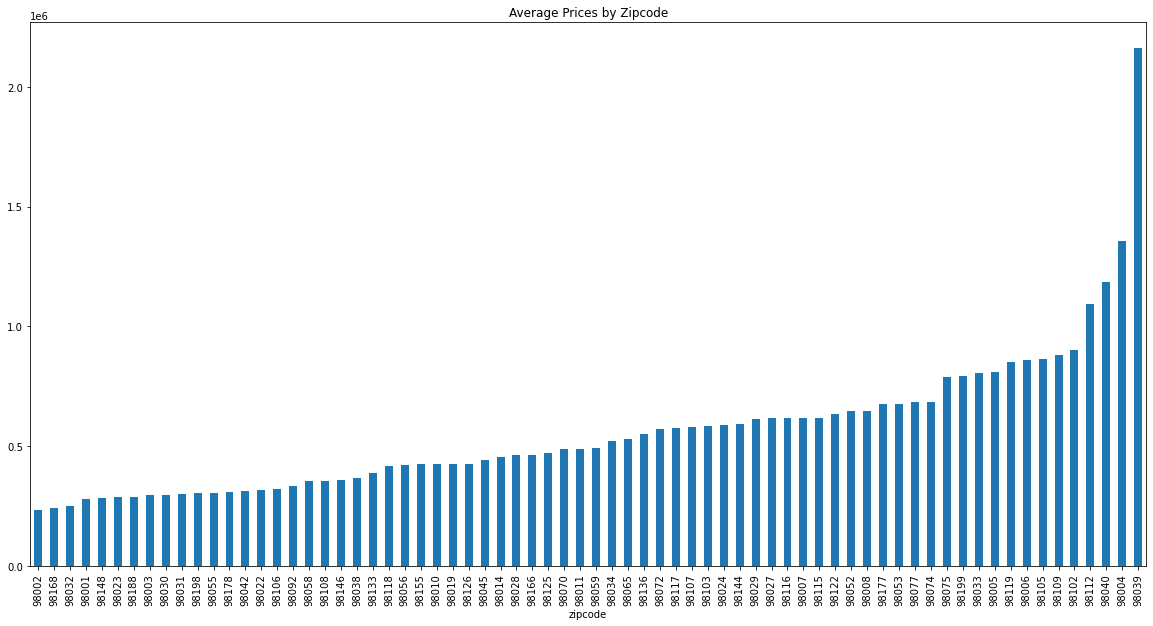

In [32]:
zipcode_pricing=df.groupby(['zipcode']).price.agg(['count','mean'])
zipcode_pricing.sort_values(by='mean',inplace=True)

fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Average Prices by Zipcode')
#pd.plotting.table(ax,zipcode_pricing[['count']],loc='upper left',colWidths=[0.2,0.2])
zipcode_pricing['mean'].plot(kind='bar',ax=ax)

We can clearly see that the zip code 98039 has significantly higher sale prices than the rest.  Looking at a [map](https://www.google.com/maps/place/Medina,+WA+98039/@47.6272552,-122.2778795,13z/data=!3m1!4b1!4m5!3m4!1s0x54906b5f7bfdac91:0x36cace7c29db7076!8m2!3d47.6258071!4d-122.2421963) of the area, one can see why for qualitative reasons:  the area covered is mostly Medina, a relatively-close suburb of Seattle alongside Puget Sound.  Taking a closer look at the price differences, we can conclude that it will be reasonable to include a dummy variable to control for sales in the 98039 zipcode (done elsewhere in our notebook.)

# Analysis and Statistical Testing

## Correlation Matrix

In [33]:
continuous_variables = ['sqft_living','sqft_outside','sqft_above', 'sqft_basement','sqft_living15','age', 'price']
df[continuous_variables].corr()['price']

sqft_living      0.701587
sqft_outside     0.075054
sqft_above       0.605695
sqft_basement    0.323018
sqft_living15    0.585304
age             -0.054218
price            1.000000
Name: price, dtype: float64

AxesSubplot(0.125,0.125;0.62x0.755)


,sqft_living,sqft_outside,sqft_above,sqft_basement,sqft_living15,age,price
sqft_living,1.000000,0.152146,0.876553,0.433369,0.756208,-0.318660,0.701587
sqft_outside,0.152146,1.000000,0.165489,0.005973,0.128841,-0.045651,0.075054
sqft_above,0.876553,0.165489,1.000000,-0.053403,0.731543,-0.424354,0.605695
sqft_basement,0.433369,0.005973,-0.053403,1.000000,0.200709,0.132915,0.323018
sqft_living15,0.756208,0.128841,0.731543,0.200709,1.000000,-0.326872,0.585304
age,-0.318660,-0.045651,-0.424354,0.132915,-0.326872,1.000000,-0.054218
price,0.701587,0.075054,0.605695,0.323018,0.585304,-0.054218,1.000000


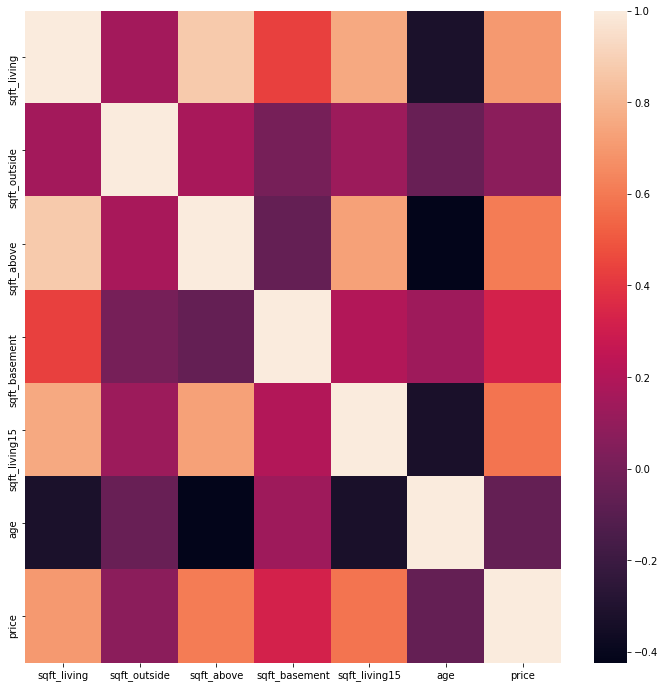

In [34]:
fig, ax = plt.subplots(figsize=(12,12))
print(sns.heatmap(df[continuous_variables].corr(), ax=ax))
display(df[continuous_variables].corr())

By examining the correlation matrix and heatmap, we notice that the size of the home is closesly related to the size of the neighboring homes. We might want deal with this multicollinearity before running the regression.

## ANOVA Renovation

Let's compare the sale price of the homes that have been renovated at different times. We leave out homes that have never been renovated in order to account for homogeneity.

In [35]:
frames=()
for status in df.renovation_status.unique():
    if(status!='Never'):
        frames+=(df[df.renovation_status==status].price,)
    else:
        pass
print(len(frames))

5


In [36]:
stats.f_oneway(*frames)

F_onewayResult(statistic=6.890184596132484, pvalue=1.9017946256943733e-05)

Despite the previous visualizations not showing a noticeable distinction in price based on renovation status, the ANOVA test results indicate that we should actually reject the null hypothesis that there is no distinction.

## ANOVA Condition

In [37]:
frames=()
for status in df.condition.unique():
    frames+=(df[df.condition==status].price,)
print(len(frames))

5


In [38]:
stats.f_oneway(*frames)

F_onewayResult(statistic=37.313586471696205, pvalue=3.778996076725189e-31)

Despite the previous visualizations not showing a noticeable distinction in price based on the condition of the house, the ANOVA test results indicate that we should actually reject the null hypothesis that there is no distinction. This conclusion is much more in line with what common sense would dictate.

## ANOVA Season

In [39]:
frames=()
for status in df.season.unique():
    frames+=(df[df.season==status].price,)
print(len(frames))

4


In [40]:
stats.f_oneway(*frames)

F_onewayResult(statistic=7.665010995309334, pvalue=4.0708073544691107e-05)

Unsurprisingly, houses are sold at different prices at different times of the year.

# Regression

In [41]:
#splitting up the dataframe between target and factors, further organized by type.
target=['price']
dense_factors=['sqft_living','sqft_outside','percent_above','sqft_living15','age', 'sqft_living2']
sparse_factors=['bedrooms','bathrooms','floors','view','grade','condition']
ordinal_factors=['renovation_status']
category_factors=['season','waterfront']
other=['zipcode','lat','long','month','day','sale_year']

Our square footage data is unsurprisngly closely related to each other. With this in mind, we can create a new variable in order to explain more with less.

In [42]:
df['percent_above']=df.sqft_above/df.sqft_living
df['neighbor_relative_living'] = df.sqft_living / df.sqft_living15

From our visualizations, it is clear that there is a strong relationship between price and living space. Although the data is rather hectic, it is worth considering the the relationship between price and living space is roughly quadratic.

In [43]:
df['sqft_living2']=df['sqft_living']**2

As a result of our data analysis, we want to create a dummy variable for houses in the zipcode 98039.

In [44]:
df['Medina']=df.zipcode.apply(lambda z:z==98039)

We also thought it would be interesting to consider the distance from downton Seattle, the city's financial and industrial center.  To measure this distance, we used the city's largest building, Columbia Center.

In [45]:
columbia_center_gps=(47.6049412,-122.3326903)

In [46]:
df['GPS']=df.apply(lambda r:(r.lat,r.long),axis=1)
df['Miles_to_Downtown']=df.GPS.apply(lambda g:geodesic(columbia_center_gps,g).miles)

In [47]:
df.Miles_to_Downtown.describe()

count    21534.000000
mean        11.478886
std          6.594997
min          0.639744
25%          6.105418
50%         10.300207
75%         15.711517
max         48.083211
Name: Miles_to_Downtown, dtype: float64

In [48]:
city_bound=7.5
print(df[df.Miles_to_Downtown<city_bound].price.mean())
print(df[df.Miles_to_Downtown>city_bound].price.mean())

665966.9935202141
478136.61558711465


There seems to be a significant difference between sale prices within our city limit boundary and outside of it.  So we will add a dummy variable to control for this factor

In [49]:
df['Seattle']=df.Miles_to_Downtown.apply(lambda x:x<city_bound)

For programming conveniuence, and as a part of the initial data exploration, we wish to organize the dataset by our target variable and different types of factors (numerical, categorical, and other).  We further divided the numerical factors into two types: dense & sparse.  The latter include factors which have limited # of different values.  Such variables, like # of bedrooms, will be modeled as continous variables but purposes of data exploration, etc. should be treated as categorical.  We also need to divide the categorical variables into binary and ordinal.  This distinction will be important in the regression stage as categorical variables will eventually be split into dummies.

In [50]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_year', 'sale_month',
       'age', 'season', 'renovation_age', 'renovation_status', 'sqft_outside',
       'sqft_outside15', 'percent_above', 'neighbor_relative_living',
       'sqft_living2', 'Medina', 'GPS', 'Miles_to_Downtown', 'Seattle'],
      dtype='object')

In [51]:
target=['price']
dense_factors=['sqft_living2','sqft_living','sqft_outside','percent_above','sqft_living15','age','neighbor_relative']
sparse_factors=['bedrooms','bathrooms','floors','view','grade']
ordinal_factors=['renovation_status']
category_factors=['season','waterfront','Seattle','Medina','renovation_status','condition']
dummies=[]
other=['zipcode','lat','long','month','day','sale_year']

Finally, we want to set these categorical factors as category dtypes.  Then we will create dummy variables for each and attach them to the main dataframe.

In [52]:
df.Seattle=df.Seattle.astype('category')
df.Medina=df.Medina.astype('category')
df.renovation_status=df.renovation_status.astype('category')
df.waterfront=df.waterfront.astype('category')
df.condition=df.condition.astype('category')
df.season=df.season.astype('category')

In [53]:
cats_df=df.copy()
ohe = OneHotEncoder(drop='first')
for c in category_factors:
    cat_trans = ohe.fit_transform(df[[c]])
    cat_df = pd.DataFrame(cat_trans.todense(), columns=ohe.get_feature_names(),index=df.index)
    cats_df=pd.merge(cats_df,cat_df,right_index=True,left_index=True,how='outer')
    dummies.extend(ohe.get_feature_names())

In [59]:
df=cats_df.copy()

## Regression

First task at this stage is to translate our categorical variables into dummy variables.

Before diving into the true model.  It may be helpful to look at some preliminary regressions

In [ ]:
lr=LinearRegression()
lr.fit(df[['sqft_living']],df[target])
print(lr.coef_)
lr.score(df[['sqft_living']],df[target])
simple_test=[df[['sqft_living']].min(),df[['sqft_living']].max()]
simple_pred=lr.predict(simple_test)
fig,ax=plt.subplots()
ax.plot(simple_test,simple_pred,color='red')
ax.scatter(df['sqft_living'],df[target])

In [ ]:
def forward_steps(data,Y,X):
    dependent=data[Y]
    Models=[[]]
    features=X.copy()
    lr=LinearRegression()
    def r_score_margin(original,new_f):
        X_Y=(data[original+[new_f]],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    while len(features)>0:
        M=Models[-1]
        new_f=max(features,key=lambda f: r_score_margin(M,f))
        features.remove(new_f)
        Models.append([new_f]+M)
    Models.remove([])
    return Models

def backward_steps(data,Y,X):
    dependent=data[Y]
    steps=len(X)
    Models=[X.copy()]
    lr=LinearRegression()
    def r_score_exmargin(original,new_f):
        ins=original.copy()
        ins.remove(new_f)
        X_Y=(data[ins],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    while steps>1:
        M=Models[-1].copy()
        worse_f=max(M,key=lambda f: r_score_exmargin(M,f))
        M.remove(worse_f)
        Models.append(M)
        steps-=1
    return Models

def subset_steps(data,Y,X):
    dimensions=X
    M=[]
    lr=LinearRegression()
    dependent=data[Y]
    def r_score_margin(inputs):
        X_Y=(data[inputs],dependent)
        lr.fit(*X_Y)
        return lr.score(*X_Y)
    for d in range(1,len(dimensions)+1):
        combos=[list(c) for c in combinations(dimensions,d)]
        top_model=max(combos,key=r_score_margin)
        M.append(top_model)
    return M

def CV_compare(data,Y,models,folds=5):
    scores={}
    lr=LinearRegression()
    state=random.randint(1,1000)
    SPLIT=KFold(folds,random_state=state,shuffle=True)
    for m in models:
        k='+'.join(m)
        scores[k]=cross_validate(lr,data[m],data[Y],cv=SPLIT)['test_score']
    return scores

In [ ]:
fwd_models=forward_steps(df,target,(dense_factors+sparse_factors+dummies))
fwd_models

In [ ]:
models_cv_scores=CV_compare(df,target,fwd_models,folds=10)

In [ ]:
models_cv_scores

In [ ]:
CV_compare(df,target,fwd_models)

In [ ]:
back_models=backward_steps(df,target,dense_factors+sparse_factors+dummies)
back_models

In [ ]:
CV_compare(df,target,back_models)

In [ ]:
sub_models=subset_steps(df,target,dense_factors+sparse_factors+dummies)
sub_models

In [ ]:
CV_compare(cats_df,target,sub_models)

In [ ]:
pf=PolynomialFeatures(2)
X=pd.DataFrame(pf.fit_transform(df[['sqft_living']]),columns=pf.get_feature_names()).drop('1',axis=1)
X

In [ ]:
lr=LinearRegression()
lr.fit(X,df[target])
lr.score(X,df[target])

In [ ]:
pf.get_params()

In [ ]:
df['sqft_living'].values.reshape(-1,1)